In [38]:
import sys
sys.path.append('../code')
from init_mooc_nb import *
init_notebook()

dims = SimpleNamespace(G=holoviews.Dimension(r'$G/G_0$'),
                       V_bias=holoviews.Dimension('$V_{bias}$'),
                       phi=holoviews.Dimension(r'$\Phi/\Phi_0$'))


def make_system_spectroscopy():

    # We apply a magnetic field in all parts of the system
    def onsite_sc(site, p):
        return (2 * p.t - p.mu_sc) * pauli.s0sz + p.Ez * pauli.sxs0 + p.delta * pauli.s0sx

    def onsite_normal(site, p):
        return (2 * p.t - p.mu_l) * pauli.s0sz + p.Ez * pauli.sxs0

    def onsite_barrier(site, p):
        return (2 * p.t - p.mu_l + p.Vbarrier) * pauli.s0sz + p.Ez * pauli.sxs0

    # The hopping is the same in all subsystems. There is normal hopping and
    # spin orbit interaction.
    def hop(site1, site2, p):
        return -p.t * pauli.s0sz + 1j * p.alpha * pauli.sysz

    lat = kwant.lattice.chain(norbs=4)
    syst = kwant.Builder()

    # The first subsystem just consists of the tunnel barrier (one site with a
    # potential)
    syst[lat(0)] = onsite_barrier

    # The second subsystem is a normal lead
    # The translational symmetry makes it semi-infinite.
    lead1 = kwant.Builder(kwant.TranslationalSymmetry(*lat.prim_vecs), conservation_law=-pauli.s0sz) 
    # Define a unit cell (in this case the unit cell consists of a single site)
    lead1[lat(0)] = onsite_normal
    # Define the hopping between unitcells
    lead1[lat(1), lat(0)] = hop

    # The third subsystem is a superconducting lead. A Majorana bound state
    # can arise at the edge of this system.
    lead2 = kwant.Builder(kwant.TranslationalSymmetry(*lat.prim_vecs)) 
    # Again: Define a unit cell
    lead2[lat(0)] = onsite_sc
    # Again define hopping between unit cells
    lead2[lat(1), lat(0)] = hop

    # Create a connection between the first subsystem (the tunnel barrier, system name: syst)
    # and the other two subsystems (the normal and the superconducting lead)
    syst.attach_lead(lead1)
    syst.attach_lead(lead2)

    syst = syst.finalized()

    return syst


def nanowire_chain(L=None, periodic=False):
    lat = kwant.lattice.chain()

    if L is None:
        syst = kwant.Builder(kwant.TranslationalSymmetry(*lat.prim_vecs))
        L = 1
    else:
        syst = kwant.Builder()

    def onsite(onsite, p):
        return (2 * p.t - p.mu) * pauli.szs0 + p.B * pauli.s0sz + p.delta * pauli.sxs0

    for x in range(L):
        syst[lat(x)] = onsite

    def hop(site1, site2, p):
        return -p.t * pauli.szs0 - .5j * p.alpha * pauli.szsx

    def hopping_with_flux(site1, site2, p):
        phase = np.exp(1j * p.flux / 2)
        phase_factors = np.kron(np.diag([phase, phase.conj()]), pauli.s0)
        return 0.7 * phase_factors @ hop(site1, site1, p)

    syst[kwant.HoppingKind((1,), lat)] = hop

    if periodic:
        syst[lat(0), lat(L - 1)] = hopping_with_flux
    return syst


def tunnel_spectroscopy(syst, p, Es):
    def Andreev_cond(E):
        sm = kwant.smatrix(syst, energy=E, args=[p])
        # (i, j) means we call for block j of lead i in the scattering matrix.
        # The normal lead is i = 0 here, where block j = 0 corresponds to electrons
        # and block j = 1 holes.
        return (sm.submatrix((0, 0), (0, 0)).shape[0] -
                sm.transmission((0, 0), (0, 0)) +
                sm.transmission((0, 1), (0, 0)))
    Gs = [Andreev_cond(E) for E in Es]
    return np.array(Gs)


def plot_spectroscopy(Vbarrier):
    syst = make_system_spectroscopy()
    Es = np.linspace(-0.15, 0.15, 101)
    p = SimpleNamespace(t=1, mu_l=0.5, mu_sc=0, alpha=0.15,
                        delta=0.1, Vbarrier=Vbarrier)

    # Trivial, because the magnetic field is zero (third argument)
    p.Ez = 0
    Gs_trivial = tunnel_spectroscopy(syst, p, Es)

    # Non-trivial
    p.Ez = 0.25
    Gs_topological = tunnel_spectroscopy(syst, p, Es)
    kdims = [dims.V_bias, dims.G]
    plot = holoviews.Path((Es, Gs_trivial), kdims=kdims, label='trivial')(style={'color': 'k'})
    plot *= holoviews.Path((Es, Gs_topological), kdims=kdims, label='topological')(style={'color': 'r'})
    style_overlay = {'xticks': [-0.1, 0.0, 0.1], 
                     'yticks': [0.0, 0.5, 1.0, 1.5, 2.0],
                     'show_legend':True, 
                     'legend_position': 'top',
                     'fig_size':150}
    style_path = {'show_legend':True}
    return plot(plot={'Overlay': style_overlay, 'Path': style_path})


def nanowire_spectrum(trivial=False):
    B = 0.2 if trivial else 1.0
    p = SimpleNamespace(mu=0.4, t=1.0, alpha=0.2, delta=0.1, B=B)
    syst = nanowire_chain(L=100, periodic=True).finalized()

    def energy(flux):
        p.flux = flux
        H = syst.hamiltonian_submatrix(args=[p])
        return np.linalg.eigvalsh(H)

    fluxes = np.linspace(0, 4 * np.pi, 51)
    spectrum = np.array([energy(flux) for flux in fluxes])

    # Find the two subgap states.
    if not trivial:
        N = spectrum.shape[1] // 2
        non_trivial = np.where((fluxes > np.pi) & (fluxes < 3 * np.pi))
        spectrum[non_trivial, N - 1: N + 1] = spectrum[non_trivial, N: N - 2: -1].copy()

    return fluxes, spectrum


def plot_spectrum_nanowire(fluxes, spectrum, ylim=[-0.2, 0.2]):
    N = spectrum.shape[1] // 2
    kdims = [dims.phi, '$E$']
    plot = holoviews.Path((fluxes, spectrum), kdims=kdims)(style={'color': 'k', 'alpha': 0.4})
    plot *= holoviews.Path((fluxes, spectrum[:, N - 1]), kdims=kdims)(style={'color': 'r'})
    plot *= holoviews.Path((fluxes, spectrum[:, N]), kdims=kdims)(style={'color': 'k'})
    ticks = {'xticks': [(0, '0'), (2 * np.pi, '1'), (4 * np.pi, '2')]}
    return plot[:, -0.11:0.11](plot=ticks)


def plot_gse_sc_nanowire(fluxes, spectrum):
    N = spectrum.shape[1] // 2
    energy_gs = np.sum(spectrum[:, :N], axis=1)
    energy_gs -= np.max(energy_gs)
    current = np.diff(energy_gs) * len(energy_gs)

    xdim = dims.phi
    ydim = r'$E_{tot}(\Phi)$'
    
    ticks = {'xticks': [(0, '0'), (2 * np.pi, '1'), (4 * np.pi, '2')]}
    plot = holoviews.Path((fluxes, energy_gs), kdims=[
                          xdim, ydim], label='Energy')(plot=ticks)
    ydim = r'$I(\Phi)$'
    plot += holoviews.Path(((fluxes[1:] + fluxes[:-1]) / 2, current),
                           kdims=[xdim, ydim], label='Current')(plot=ticks)
    return plot


Populated the namespace with:
np, matplotlib, kwant, holoviews, init_notebook, SimpleNamespace, pprint_matrix, scientific_number, pretty_fmt_complex, plt, pf, display_html
from code/edx_components:
MoocVideo, PreprintReference, MoocDiscussion, MoocCheckboxesAssessment, MoocMultipleChoiceAssessment, MoocPeerAssessment, MoocSelfAssessment
from code/functions:
spectrum, hamiltonian_array, h_k, pauli
Using kwant 1.3.2 and holoviews 1.9.5
Executed on 2018-03-18 at 13:23:34.696581.


# How to detect Majoranas

Our second guest lecturer for this week is Carlo Beenakker, from Leiden University.

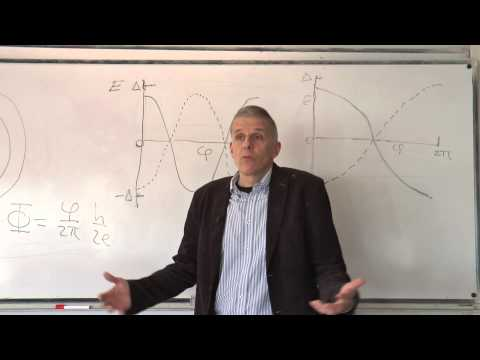

In [2]:
MoocVideo("WAhNblNbadA", src_location="2.2-intro")

# Andreev reflection

To understand how conductance through a Majorana works, we first have to learn how charge is transferred from a metallic lead to a superconductor. In general this transfer takes place via a mechanism known as Andreev reflection. Before we discuss the conductance signatures of a Majorana zero mode, it is useful to learn what Andreev reflection is.

Let's consider the following very simple circuit with two electrodes:

![](figures/ns_interface.svg)

One electrode is a normal metal, the other a superconductor, and they are kept at a voltage difference $V$. At the interface between the normal metal and the superconductor (in short, NS interface) there is a barrier. We are particularly interested in the case when the voltage difference is very small compared to the energy gap in the superconductor, $eV < \Delta$, where $e$ is the charge of the electron.

What happens when electrons arrive at the interface with superconductor? The superconductor has no states available up to an energy $\Delta$ around the Fermi level, and the voltage is not enough to provide for this energy difference. How can a current develop?

To understand this, let's look more closely at an electron arriving at the interface with the superconductor. There are two possible processes that can take place, *normal reflection* and *Andreev reflection*. In normal reflection, the electron is simply reflected at the interface with the superconductor:

![](figures/normal_reflection.svg)

With normal reflection, there is no net charge transfer from the left electrode to the right electrode. Hence this process does not contribute any net current. Normal reflection obviously doesn't even require a superconductor and would take place also if the right electrode was normal.

Andreev reflection, instead, is unique to the NS interface. In Andreev reflection, an electron is converted to a hole by the superconductor, and a Cooper pair is created in the superconductor.

![](figures/andreev_reflection.svg)

You can see that a net charge of $2e$ is transferred from the left to the right electrode, and at low voltages Andreev reflection is the only process responsible for the electrical current.

Above the superconducting gap, $eV > \Delta$ transmission of an incident electron into the superconductor also contributes to the current.

You can also think of Andreev *reflection* as a *transmission* problem. Because of the presence of the superconductor, both electrons and holes participate in the transfer of charge in the normal metal lead. Conceptually, you can imagine to separate the left lead into two leads, one only carrying electrons and one only carrying holes. These two leads are connected by the superconductor, which converts incoming electrons in the first lead into outgoing holes in the second lead, and viceversa:

![](figures/andreev_as_transmission.svg)

With this picture, you can understand that Andreev reflection is very similar to the problem of transmission through a double barrier.

Let's call $r_{eh}$ the amplitude for Andreev reflection. Its absolute value squared, $\left|r_{eh}\right|^2$, is the probability that an incoming electron from the normal metal is Andreev reflected as a hole. Once we know $r_{eh}$, we can compute the conductance $G(V)$, which relates the current $I$ that develops as a response to a small voltage $V$, $G(V) = dI/dV$. The conductance is given by the following formula:

$$G(V)=2G_0|r_{eh}|^2.$$

We will not derive this equation, since it can be understood intuitively. The conductance is proportional to the probability $|r_{eh}|^2$ of Andreev reflection, since we know that at low voltages this is the only process that transfers electric charge from the left to the right electrode.

The factor of $2$ is due to each Andreev reflection transferring a charge of a Cooper pair, $2e$. Finally, $G_0=e^2/h$ is the **conductance quantum**, the fundamental proportionality constant which relates currents to voltages.

# Andreev reflection off a Majorana zero mode

Now that we understand a conventional NS interface, let's see what happens if our superconductor is topological:

![](figures/ns_majorana_interface.svg)

You can imagine that the superconducting electrode is now a nanowire in the topological phase, like the one you have just studied. Because the superconductor is topological, there is a Majorana mode at the NS interface, whose wave function will “leak” a bit into the normal metal, through the barrier. Of course, there will be also a second Majorana mode, but we place it far enough from the NS interface, so that it does not have a role in the transport. Does the Majorana zero mode at the interface change the Andreev reflection properties?

Yes, and in a rather drastic way. Going back to the picture of Andreev reflection as a transmission process through a double barrier, the crucial difference is that the Majorana mode now appears as a bound state between the two barriers:

![](figures/resonant_transmission_through_majorana.svg)

In the double barrier problem in quantum mechanics, you can have **resonant** transmission in the presence of a bound state. This means that the probability $\left|r_{eh}\right|^2$ to pass through the barriers is dramatically enhanced if the energy of the incident electron matches the energy of the bound state. In our case, the energy of the incident electron is $V$, and the energy of the bound state, the Majorana mode, is zero. So the presence of the Majorana mode leads to a **resonant peak** in the conductance of the NS interface at $V=0$.

# Quantization of the Majorana resonance

Seeing the resonant peak is the most direct way we know to measure the presence of a Majorana zero mode.

However, the presence of a resonance associated with Majorana modes is not uniquely topological, because tunneling into any low energy bound state produces resonance.

Is there anything in particular which distinguishes the Majorana resonance from any other resonance?

Let's just look at what happens if we compare conductance of an NS interface in the cases when S is trivial and non-trivial, and see how the conductance changes as we alter the tunnel barrier strength.

In [16]:
holoviews.plotting.mpl.MPLPlot.fig_rcparams['text.usetex'] = False
holoviews.HoloMap({V: plot_spectroscopy(V) for V in np.arange(1, 4.25, 0.25)}, kdims=[r'$V_{barrier}$'])

:HoloMap   [$V_{barrier}$]
   :Overlay
      .Path.Trivial     :Path   [$V_{bias}$,$G/G_0$]
      .Path.Topological :Path   [$V_{bias}$,$G/G_0$]

We see a very robust and persistent characteristic:
the peak height of the Majorana resonance is quantized to the value of $2G_0$, independent of the strength of the voltage barrier. From the formula above, this means that if a Majorana is present we have $\left|r_{eh}\right|^2=1$, that is we have **perfect Andreev reflection**.

To understand why it is robust, we need to go beyond drawing cartoon figures.

## Reflection matrix of a normal metal-superconductor interface

Quantum-mechanically, we can describe transport through the NS interface as a scattering problem. An incoming wave function $\Psi_\textrm{in}$ propagates in the left electrode, until it is reflected back at the interface with the superconductor, turning into an outgoing wave function $\Psi_\textrm{out}$. Because of the presence of the superconductor, both the incoming and outgoing states can be electrons $\Psi_e$ or holes $\Psi_h$. At **zero energy**, they are related to each other by particle-hole symmetry:

$$\Psi_e(E) = \mathcal{P}\,\Psi_h(-E)\,$$

The reflection enforces a linear relation between incoming and ingoing waves:

$$\Psi_\textrm{out} = r(V) \,\Psi_\textrm{in}\,$$

$$r(V)=\left(\begin{array}{cc}r_{ee}&r_{eh}\\r_{he}&r_{hh}\end{array}\right).$$

The matrix $r$ is known as the **reflection matrix**. Its complex elements are the amplitudes of normal and Andreev reflection of an incoming electron - $r_{ee}$ and $r_{eh}$ - and normal and Andreev reflection of an incoming hole - $r_{hh}$ and $r_{he}$. (For brevity we don't write out explicitly that each of those depends on $V$.)

If there is more than one incoming electron state (in our case there are two due to spin), all 4 elements of $r$ become matrices themselves. They then describe scattering between all the possible incoming and outgoing states.

Because for $eV\ll \Delta$ there are no propagating waves in the superconductor, the reflection process which relates $\Psi_\textrm{out}$ and $\Psi_\textrm{in}$ is unitary, $r^\dagger r=1$. This implies that

$$\left|r_{ee}\right|^2+\left|r_{eh}\right|^2 = \left|r_{he}\right|^2+\left|r_{hh}\right|^2 = 1\,.$$

This is the mathematical way of saying that an electron (or hole) arriving at the interface has no alternatives other than being normal-reflected or Andreev-reflected.

Can we add any other constraint to $r$, that might help to distinguish any characteristic of the Majorana mode? Just like we did last week, let's try to study $r$ using symmetry and topology. Our circuit involves a superconductor, so we must have particle-hole symmetry in the problem.

In order to derive $r$ explicitly we could start directly from the Bogoliubov-de Gennes Hamiltonian of the NS system, and solve it for an energy $V$. This is a lot of work, which we won't do, but knowing this fact we can understand the consequences of particle-hole symmetry for $r$.

First, particle-hole symmetry exchanges electrons and hole components of the wave function, so it involves a Pauli matrix $\tau_x$ acting on $\Psi_\textrm{in}$ or $\Psi_\textrm{out}$. Second, it is an anti-unitary symmetry, so it involves complex conjugation. Third, it changes the sign of the energy so it sends $V$ into $-V$. Hence we arrive at the following symmetry for the reflection matrix:

$$\tau_x r^*(-V) \tau_x = r(V)\,.$$

Together with unitarity, particle-hole symmetry imposes that the conductance is symmetric around zero voltage, $G(V)=G(-V)$. In the most interesting point, $V=0$ we have:

$$ \tau_x r^*_0 \tau_x = r_0 \,.$$

where we defined $r_0\equiv r(V=0)$. So much for the impact of symmetry on $r$. What about topology?

# Topological invariant of the reflection matrix

The Majorana zero mode is the consequence of a topological phase in the topological superconductor, and its presence is dictated by the bulk-boundary correspondence. Can we find any consequence of this fact in $r_0$? It turns out that reflection matrices $r$ with particle-hole symmetry are also topological in their own way. Their topological invariant is 

$$Q = \det\,r_0\,.$$

Again, we will not *derive* this equation, but rather convince ourselves this expression is correct.

First of all, the determinant of a unitary matrix such as $r_0$ is always a complex number with unit norm, so $\left|\det\,r_0\,\right|=1$. Second, because of particle-hole symmetry, the determinant is real: $\det r_0 = \det\, (\tau_x r^*_0\,\tau_x) = \det\,r_0^*\,=(\det\,r_0)^*$. Hence, $\det\,r_0\,= \pm 1$. This is quite promising! Two possible discrete values, just like the Pfaffian invariant of the Kitaev chain.

Because it is just dictated by unitarity and particle-hole symmetry, the determinant of $r_0$ cannot change from $+1$ to $-1$ under a change of the properties of the NS interface. For instance, you can vary the height of the potential barrier at the interface, but this cannot affect the determinant of $r_0$.

The only way to make the determinant change sign is to close the bulk gap in the superconducting electrode. If the gap goes to zero, then it is not true that an incoming electron coming from the normal metal can only be normal-reflected or Andreev-reflected. It can also just enter the superconducting electrode as an electron. Hence the reflection matrix no longer contains all the possible processes taking place at the interface, and it won't be unitary anymore. This allows the determinant to change sign. We conclude that $Q=\det\,r$ is a good topological invariant.

Explicitly, we have that

$$Q=|r_{ee}|^2-|r_{eh}|^2\equiv\pm 1\,.$$

We already saw that unitarity requires that $|r_{ee}|^2+|r_{eh}|^2=1$. There are only two possibilities for both conditions to be true: either $|r_{ee}|=1$ (**perfect  normal reflection**) or $|r_{eh}|=1$ (**perfect Andreev reflection**). The situation cannot change without a phase transition. Thus the quantized conductance of the Majorana mode is topologically robust in this case, and in fact survives past the tunneling limit. 

In [6]:
question = ("Imagine we replace the superconducting electrode with an insulating material, "
            "and imagine that at the interface with the normal metal there is a bound state. "
            "How is the current through the interface different with respect "
            "to that through an NS interface with a Majorana?")
answers = ["It is not quantized but still non-zero.",
           "It is zero because there cannot be Andreev reflection without a superconductor.",
           "It is not symmetric in voltage but it is still non-zero.",
           "It has a resonance peak whose width is independent of the barrier strength."]
explanation = ("A current requires an exit path for the charge. "
               "No current can flow through the insulator, since there are no excitations at the Fermi level in an insulator. "
               "A superconductor is also gapped with respect to excitations, but is different than a normal insulator. "
               "It has a condensate of Cooper pairs, so a current can develop thanks to Andreev reflection at the interface.")
MoocMultipleChoiceAssessment(question, answers, correct_answer=1, explanation=explanation)

MoocMultipleChoiceAssessment(**{'explanation': 'A current requires an exit path for the charge. No current can flow through the insulator, since there are no excitations at the Fermi level in an insulator. A superconductor is also gapped with respect to excitations, but is different than a normal insulator. It has a condensate of Cooper pairs, so a current can develop thanks to Andreev reflection at the interface.', 'display_name': 'Question', 'max_attempts': 2, 'correct_answer': 1, 'answers': ['It is not quantized but still non-zero.', 'It is zero because there cannot be Andreev reflection without a superconductor.', 'It is not symmetric in voltage but it is still non-zero.', 'It has a resonance peak whose width is independent of the barrier strength.'], 'question': 'Imagine we replace the superconducting electrode with an insulating material, and imagine that at the interface with the normal metal there is a bound state. How is the current through the interface different with respect to that through an NS interface with a Majorana?'})

# Flux-induced fermion parity switch in topological superconductors

How do we probe the Pfaffian topological invariant of a topological superconductor directly? Last week, we introduced a thought-experiment where we probed the bulk-edge correspondence of Majorana modes by changing the sign of the hopping across a bond. The non-trivial value of the topological invariant results in a fermion parity switch as a result of the change in sign of the hopping $t$ across the junction i.e. 

$$t\rightarrow -t.$$

It turns out that the sign change in the hopping across the junction might also be obtained by introducing a magnetic flux through the superconducting ring (similar to the [Aharonov-Bohm effect](http://en.wikipedia.org/wiki/Aharonov-Bohm_effect)). The role of the special bond is now played by a Josephson junction, which is just an insulating barrier interrupting the ring, as in the following sketch:

![](figures/josephson_majorana_ring.svg)

How does the magnetic flux enter the Hamiltonian? By following the usual argument for introducing magnetic fields into lattice Hamiltonians using [Peierls substitution](http://topocondmat.org/w2_majorana/Peierls.html), the flux $\Phi$ can be accounted for simply by changing the phase of the hopping across the junction in the ring:

$$t\,\to\,t\,\exp (i\phi/2).$$

Here, $\phi = 2\pi\Phi/\Phi_0$ is usually called the **superconducting phase difference** across the junction, and $\Phi_0=h/2e$ is the **superconducting flux quantum**. Notice that when $\Phi=\Phi_0$ the hopping changes sign: $t \,\to\, \exp (i\pi) t = -t$, exactly as we had last week!

> Thus, the introduction of a flux quantum $\Phi=\Phi_0$, changes the sign of the hopping $t\rightarrow t e^{i\phi}=-t$, which as discussed last week changes the fermion parity of the ground state for topological superconductors. This fermion parity switch is related to a pair of Majorana modes coupled at the junction (as in the figure above).

To see how this happens explicitly, let's look at the spectrum of a topological superconducting ring as a function of flux,  obtained using our nanowire model:

In [39]:
holoviews.plotting.mpl.MPLPlot.fig_rcparams['text.usetex'] = False
fluxes, spectrum = nanowire_spectrum()
plot_spectrum_nanowire(fluxes, spectrum)

:Overlay
   .Path.I   :Path   [$\Phi/\Phi_0$,$E$]
   .Path.II  :Path   [$\Phi/\Phi_0$,$E$]
   .Path.III :Path   [$\Phi/\Phi_0$,$E$]

Staring at the spectrum we see that, lo and behold, the fermion parity switch appears, around $\Phi=\Phi_0/2$. Can we measure this fermion parity switch in our superconducting ring?

# Detecting the fermion parity switch using the Josephson effect

The change in fermion parity of the ground state can be detected using the so-called [Josephson effect](http://en.wikipedia.org/wiki/Josephson_effect). The Josephson current can be computed from the expectation value of the derivative of the energy operator with respect to flux,

$$I(\Phi)=\frac{1}{2}\frac{d E_\textrm{tot}(\Phi)}{d \Phi},$$

where $E_\textrm{tot}(\Phi)=\left\langle H_{BdG}(\Phi)\right\rangle$ is the total energy of the system corresponding to the BdG Hamiltonian $H_{BdG}(\Phi)$. 

>The key idea to detecting the ground state fermion parity switch is to note that changing the flux $\Phi$ adiabatically cannot change the fermion parity of the system. If you start with the system in the ground state and advance the magnetic flux from $\Phi$ to $\Phi+\Phi_0$, you end up in an excited state, because in the meantime the fermion parity has changed. To go back to the initial ground state with the same fermion parity, you need to advance $\Phi$ by $2\Phi_0$.

Note that this argument relies on the absence of a reservoir of electrons, such as a metallic lead. In this case, when the two levels cross at zero energy and the ground state fermion parity changes, there is no electron that can enter or leave the system. 

The fermion parity switch, together with fermion parity conservation of the ring, result in the energy $E_\textrm{tot}(\Phi)$ and the corresponding current (that can be measured) showing a $2\Phi_0$ periodicity in $\Phi$ - that is, a $4\pi$ periodicity in $\phi$:

In [9]:
fluxes, spectrum = nanowire_spectrum()
plot_gse_sc_nanowire(fluxes, spectrum)

:Layout
   .Path.Energy  :Path   [$\Phi/\Phi_0$,$E_{tot}(\Phi)$]
   .Path.Current :Path   [$\Phi/\Phi_0$,$I(\Phi)$]

At this point you might wonder, what is so unique about the $2\Phi_0$ periodicity of the Josephson effect?

To answer this question, we need to review an alternative way of thinking about the Josephson effect in terms of just connecting a pair of superconductors by a junction without having to wrap the superconductor in a ring. In this case,  the hopping phase  $\phi$ (which we also referred to as the *superconducting phase*) that appeared in the tunneling term proportional to $t e^{i\phi/2}$ can be eliminated by shifting the fermion operators on one side of the junction by a phase i.e.  $c^\dagger\rightarrow c^\dagger e^{-i\phi/2}$. For superconducting systems, this transformation has the interesting effect of changing the superconducting phase on one side of the junction as 

$$\Delta\rightarrow \Delta e^{i\phi}.$$ 

Now you see why $\phi$ was referred to as *superconducting phase* in the first place. After this transformation (also called a gauge transformation) $\phi$ really becomes the complex phase of the superconducting term proportional to $\Delta$.

> But this also tells you one more thing - following the gauge transformation the Hamiltonian $H_{BdG}$ only depends on $\phi$ through the term $\Delta e^{i\phi}$, so one expects the energy to be $2\pi$ periodic in $\phi$. This leads to the conventional wisdom that the Josephson effect is $2\pi$-periodic (or equivalently $\Phi_0$-periodic in the case of a ring). 

As seen from the plots below, this is exactly what happens in the non-topological phase. In this case, when we look at the energy spectrum, no fermion parity switches appear:

In [10]:
fluxes, spectrum = nanowire_spectrum(trivial=True)
plot_spectrum_nanowire(fluxes, spectrum, ylim=[-0.11, 0.11])

:Overlay
   .Path.I   :Path   [$\Phi/\Phi_0$,$E$]
   .Path.II  :Path   [$\Phi/\Phi_0$,$E$]
   .Path.III :Path   [$\Phi/\Phi_0$,$E$]

In turn, this means that energy and current are periodic with period $\Phi_0$:

In [11]:
fluxes, spectrum = nanowire_spectrum(trivial=True)
plot_gse_sc_nanowire(fluxes, spectrum)

:Layout
   .Path.Energy  :Path   [$\Phi/\Phi_0$,$E_{tot}(\Phi)$]
   .Path.Current :Path   [$\Phi/\Phi_0$,$I(\Phi)$]

At this point, you might be a little worried about how the topological superconductor managed to get around this *conventional wisdom*. The answer is subtle, and relies on the implicit assumption of the ground state fermion parity of the junction being fixed as one changes $\phi$. Topological superconductors violate this assumption and therefore can create the $4\pi$ periodic (or fractional) Josephson effect. 

In [12]:
question = ("Suppose that in your topological nanowire junction, positive energy quasiparticles can escape "
            "into a reservoir very quickly, making the junction always relax to the ground state. "
            "How would this affect the periodicity of the Josephson effect?")
answers = ["It would make the periodicity random because of the quasiparticles jumping around randomly.",
           "If the system can always relax to the ground state, the current would have a period of $\Phi_0$ (hence $2\pi)$.",
           "Since the Josephson effect is topologically protected, these processes have no effect on the periodicity.",
           "The period becomes $\Phi_0/2$ because it is easier for the quasiparticles to jump out at this value of the flux."]
explanation = ("A particle tunneling out means that the fermion parity of the ground state changes. "
              "Hence the lowest between the red and black energy levels is always occupied, and both energy and current "
              "turn out to have a period $\Phi_0$.")
MoocMultipleChoiceAssessment(question, answers, correct_answer=1, explanation=explanation)

MoocMultipleChoiceAssessment(**{'explanation': 'A particle tunneling out means that the fermion parity of the ground state changes. Hence the lowest between the red and black energy levels is always occupied, and both energy and current turn out to have a period $\\Phi_0$.', 'display_name': 'Question', 'max_attempts': 2, 'correct_answer': 1, 'answers': ['It would make the periodicity random because of the quasiparticles jumping around randomly.', 'If the system can always relax to the ground state, the current would have a period of $\\Phi_0$ (hence $2\\pi)$.', 'Since the Josephson effect is topologically protected, these processes have no effect on the periodicity.', 'The period becomes $\\Phi_0/2$ because it is easier for the quasiparticles to jump out at this value of the flux.'], 'question': 'Suppose that in your topological nanowire junction, positive energy quasiparticles can escape into a reservoir very quickly, making the junction always relax to the ground state. How would this affect the periodicity of the Josephson effect?'})

# Summary

In [ ]:
MoocVideo("sSacO5RpW5A", src_location="2.2-summary")

In [ ]:
MoocDiscussion('Questions', 'Signatures of Majorana modes')